# Quantitative function prediction across an enzyme family 

This notebook contains the machine learning implementation (using scikit-learn) for "Quantitative function prediction across an enzyme family". 

The notebook has three major parts: first, collect and join the feature sets. The feature sets for this application have one protein as each sample, and about 50 structural features as the columns. 

One question I have is: does it matter if I scale the features for all the possible point mutations (where n ~ 10,000), or should I wait to scale them until I join them with the experimenetal data (where n=100)?

In [38]:
import pandas
%matplotlib inline
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn import model_selection, linear_model, preprocessing

In [39]:
proteins = 'bglb run_A run_B run_C'.split()
targets = 'kcat km kcatkm'.split()

In [40]:
def get_dfs():
    for p in proteins:
        path = '../feature_sets/{}__enzyme_design.h5'.format(p)
        df = pandas.read_hdf(path)
        print(p, df.shape)
        df['ortholog'] = p
        yield df 
        
df = pandas.concat(get_dfs())
df['mutant_name'] = df.index 
df.set_index(['ortholog', 'mutant_name'], inplace=True)
df.sample(10)

bglb (7967, 59)
run_A (7607, 59)
run_B (8650, 59)
run_C (8613, 59)


total_score    fa_rep  hbond_sc  all_cst  tot_pstat_pm  \
ortholog mutant_name                                                           
run_B    I383V          -2273.343   517.885   -49.408      0.0         0.562   
         A279N          -2024.397   738.694   -50.768      0.0         0.559   
run_A    Y26D           -2537.730   381.751   -84.120      0.0         0.574   
run_B    G301E          -1277.435  1255.456   -49.280      0.0         0.547   
run_A    R215G          -2539.659   384.635   -84.505      0.0         0.592   
         V267I          -2327.038   473.913   -83.868      0.0         0.570   
bglb     D25L           -2725.814   437.585   -82.382      0.0         0.646   
run_C    R295Y          -3009.362   340.489   -89.589      0.0         0.588   
bglb     E317R          -1454.559   538.024   -81.986      0.0         0.652   
         I106R          -2050.082   549.036   -81.275      0.0         0.648   

                      tot_nlpstat_pm  tot_burunsat_pm  tot_hbond_pm  \
ortholog mutant_name                                                  
run_B    I383V                 0.553            214.2         372.0   
         A279N                 0.550            216.2         372.6   
run_A    Y26D                  0.573            168.0         408.4   
run_B    G301E                 0.550            218.0         371.3   
run_A    R215G                 0.582            165.4         407.9   
         V267I                 0.570            166.8         408.7   
bglb     D25L                  0.640            166.0         416.9   
run_C    R295Y                 0.580            149.7         430.4   
bglb     E317R                 0.646            166.4         418.2   
         I106R                 0.641            168.7         416.6   

                      tot_NLconts_pm  tot_nlsurfaceE_pm        ...         \
ortholog mutant_name                                           ...          
run_B    I383V                 190.1             69.501        ...          
         A279N                 189.4             69.437        ...          
run_A    Y26D                  212.1             11.748        ...          
run_B    G301E                 190.2             69.450        ...          
run_A    R215G                 213.7             11.749        ...          
         V267I                 212.6             11.747        ...          
bglb     D25L                  265.9              3.618        ...          
run_C    R295Y                 241.5             20.532        ...          
bglb     E317R                 265.4              3.504        ...          
         I106R                 263.6              3.549        ...          

                      SR_4_nlpstat_pm   SR_5  SR_5_total_score  SR_5_fa_rep  \
ortholog mutant_name                                                          
run_B    I383V                  0.647  482.0            -7.564        2.719   
         A279N                  0.580  482.0            -7.644        2.656   
run_A    Y26D                   0.708  450.0            -9.295        1.810   
run_B    G301E                  0.678  482.0            -7.384        2.700   
run_A    R215G                  0.677  450.0            -9.230        1.885   
         V267I                  0.624  450.0            -9.184        1.859   
bglb     D25L                   0.813  446.0            -7.487        1.965   
run_C    R295Y                  0.798  480.0            -6.292        1.561   
bglb     E317R                  0.815  446.0            -7.393        2.078   
         I106R                  0.719  446.0            -7.053        2.063   

                      SR_5_hbond_sc  SR_5_all_cst  SR_5_interf_E_1_2  \
ortholog mutant_name                                                   
run_B    I383V               -1.881         0.654            -11.124   
         A279N               -1.908         0.657            -11.288   
run_A    Y26D                -3.024         0.

In [41]:
df.shape

(32837, 59)

In [42]:
def feature_selection(df, drop_columns=[]):
    dropme = []
    for col in df.columns:
        if df[col].dtype == 'float64':
            if df[col].std() == 0:
                dropme.append(col)
    dropme = dropme + drop_columns 
    return df.drop(dropme, axis=1)

df = feature_selection(df)
df.shape

(32837, 57)

Now we need a fitted elastic net model 

In [43]:
b = pandas.read_csv('../data_sets/speculative_targets.csv', index_col=0)
b.head()

,kcat,km,kcatkm,expression
mutant_name,,,,
S14A,-0.439333,0.217484,-0.651460,1
T15A,-0.156314,0.025306,-0.176657,1
S16A,-0.756962,0.447468,-1.199275,1
S17A,-0.016087,0.567026,-0.577999,1
S17E,-0.137625,0.165541,-0.298065,1


In [44]:
J = b.join(df.loc[('bglb', )])
J.head()

,kcat,km,kcatkm,expression,total_score,fa_rep,hbond_sc,tot_pstat_pm,tot_nlpstat_pm,tot_burunsat_pm,...,SR_4_nlpstat_pm,SR_5,SR_5_total_score,SR_5_fa_rep,SR_5_hbond_sc,SR_5_all_cst,SR_5_interf_E_1_2,SR_5_dsasa_1_2,SR_5_hbond_pm,SR_5_burunsat_pm
mutant_name,,,,,,,,,,,,,,,,,,,,,
A192S,0.031408,0.007748,0.028609,1,-2726.385,437.294,-80.868,0.650,0.646,167.4,...,0.787,446.0,-7.343,2.000,-2.421,2.170,-10.684,0.902,5.7,0.0
A227W,-0.362874,0.531479,-0.889390,1,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A236E,NaN,NaN,NaN,0,-1554.350,1286.338,-81.957,0.651,0.645,167.3,...,0.850,446.0,-7.523,2.004,-2.578,2.015,-11.049,0.895,6.1,0.0
A249E,NaN,NaN,NaN,0,-2325.863,509.355,-81.566,0.650,0.645,168.3,...,0.862,446.0,-7.988,1.909,-2.567,1.144,-11.977,0.885,6.1,0.0
BglB,0.000000,0.000000,0.000000,1,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [45]:
feature_cols = list(J.columns[4:])
trained_models = {}
results = {}
for k in targets:
    scaler = preprocessing.MinMaxScaler()
    K = J[[k] + feature_cols].dropna()
    print(K.shape)
    X, y = K.iloc[:, 1:], K.iloc[:, 0]
    X = scaler.fit_transform(X)
#     clf = gaussian_process.GaussianProcessRegressor(alpha=1e-3)
#     clf = ensemble.BaggingRegressor(linear_model.ElasticNetCV(cv=10, normalize=True, n_alphas=1e3, max_iter=1e4))
    clf = linear_model.ElasticNetCV(cv=10, normalize=True, n_alphas=1e3, max_iter=1e4)
    clf.fit(X, y)
    pred = clf.predict(X)
#     pred = model_selection.cross_val_predict(clf, X, y, cv=10, n_jobs=-1)
    pkg = {k: clf} 
    trained_models.update(pkg)
    pkg = {k: {'y': y, 'pred': pred}}
    results.update(pkg) 

(106, 58)
(106, 58)
(106, 58)


Plots of our models

/Users/alex/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


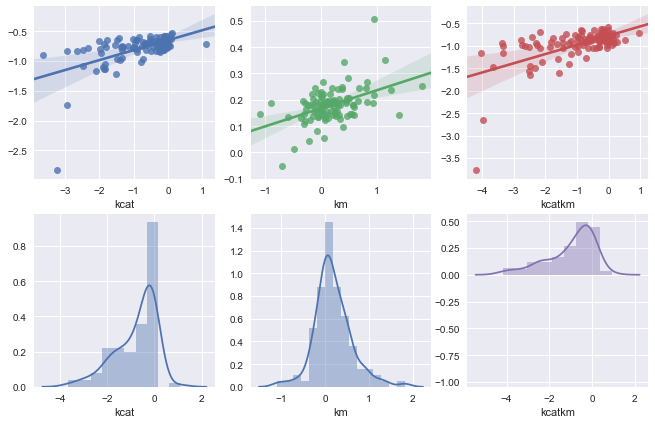

In [46]:
fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(11, 7))
for n, k in enumerate(targets):
    y, pred = results[k]['y'], results[k]['pred']
    sns.regplot(y, pred, ax=ax[0, n])
    sns.distplot(y, ax=ax[1, n])

Prepare data sets

In [47]:
run_to_scaffold = {
    'bglb': 'P22505', 
    'run_A': 'Q7MG41', 
    'run_B': 'Q97AX4', 
    'run_C': 'Q59976'
}

scaffold_to_run = {v: k for k, v in run_to_scaffold.items()}

In [48]:
dat = pandas.read_csv('../data_sets/Caster2017.csv', index_col=0)
dat[['scaffold', 'JGI_ID']] = dat['scaffold'].str.split('_', expand=True)
dat['run'] = dat['scaffold'].map(scaffold_to_run)
dat.set_index(['run', 'mutant_name'], inplace=True)
dat = dat[(dat.rel_or_abs == 'rel')]
dat.sample(5)

,,value,mutant_name_index,kinetic_constant,rel_or_abs,scaffold,JGI_ID
run,mutant_name,,,,,,
run_A,S246R,-0.297244,1,kcatkm,rel,Q7MG41,142
run_B,A262Y,0.579784,10,km,rel,Q97AX4,139
bglb,N293Q,-0.780407,8,km,rel,P22505,16
run_B,N313Q,-0.780944,8,kcatkm,rel,Q97AX4,139
run_A,Q27A,-4.074688,4,kcatkm,rel,Q7MG41,142


In [51]:
results = {}
for k in targets:
    for p in proteins:        
        y = dat.loc[(p, )]
        y = y[(y.kinetic_constant == k)][['value']]
        J = y.join(df.loc[(p, )]).dropna()
        X = J.iloc[:, 1:]
        y = J.iloc[:, 0]
        trained_model = trained_models[k]
        if len(X) > 0:
            pred = trained_model.predict(X)
            pkg = {(p, k): {'y': y, 'pred': pred}}
            results.update(pkg)
            print(k, J.shape)

kcat (9, 58)
kcat (8, 58)
kcat (9, 58)
km (9, 58)
km (8, 58)
km (9, 58)
kcatkm (9, 58)
kcatkm (8, 58)
kcatkm (9, 58)


/Users/alex/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:4: PerformanceWarning: indexing past lexsort depth may impact performance.


/Users/alex/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


KeyError: ('run_C', 'kcat')

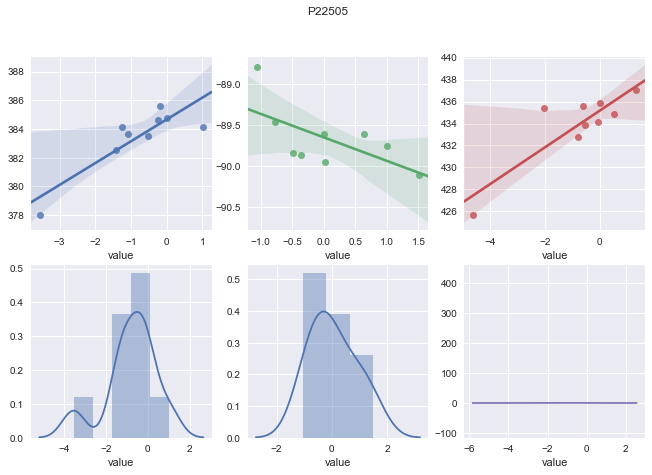

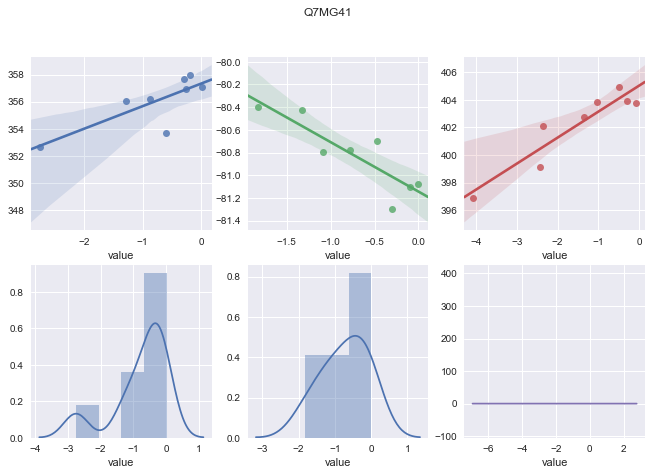

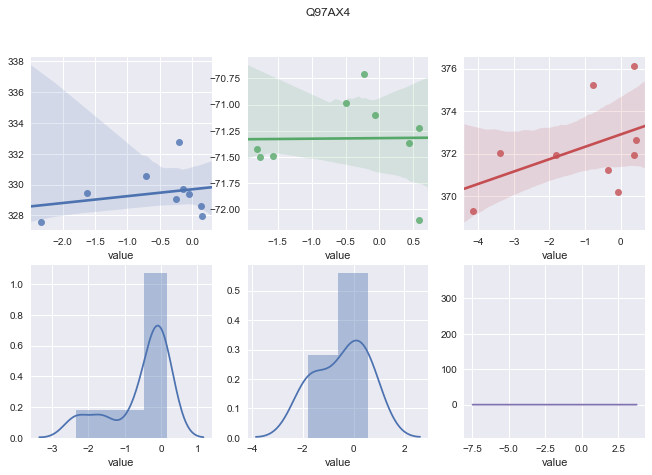

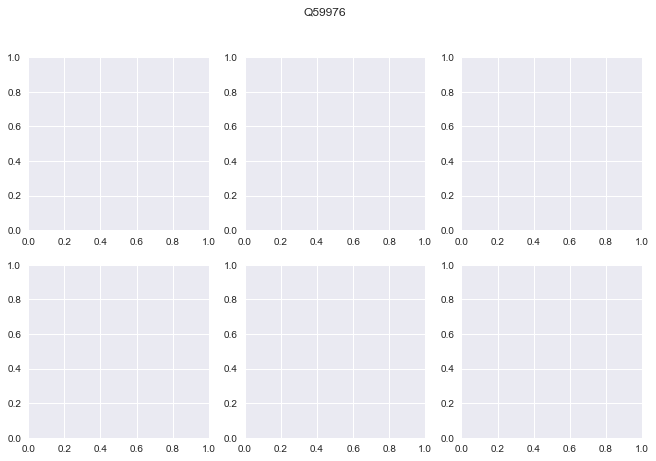

In [52]:
for p in proteins:
    fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(11, 7))
    fig.suptitle(run_to_scaffold[p])
    for n, k in enumerate(targets):
        y, pred = results[p, k]['y'], results[p, k]['pred']
        sns.regplot(y, pred, ax=ax[0, n])
        sns.distplot(y, ax=ax[1, n])